# SCANPY - PAGA - Differential analysis

In [1]:
#conda activate scRNA
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import os
import csv
from astropy.io import ascii
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN
import warnings
from matplotlib_venn import venn3
from pathlib import Path
import sys
from itertools import combinations
from importlib import reload

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

warnings.filterwarnings('ignore')
code_dir = os.getcwd()
code_dir
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.4 numpy==1.19.2 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


In [2]:
code_dir = os.getcwd()
base_dir = code_dir.replace("/codes_local","")
parent_dir = "/".join(base_dir.split("/")[:-1])
tools_dir = parent_dir + "/tools"

sys.path.insert(1, tools_dir)
import sc_addons
reload(sc_addons)

sp_name = base_dir.split("/")[-1]
analysis_name = ["0", "all"]

wk_dir = base_dir + "/1_Scanpy/%s-%s_Scanpy_out"%(analysis_name[0],analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)

print(sp_name, analysis_name)

1_IL2RAKO ['0', 'all']


-----

### Info: IL2RAKOSc Expressional Level Differential Analysis
1. **Cluster v.s. Cluster** <br>
    1.1 One v.s. all <br>
    1.2 One v.s. one (with all cells) <br>

2. **WT v.s. KO** <br>
    2.1 KO v.s. WT v.s. Naive in all cells <br>
    2.2 KO v.s. WT in each cluster <br>

---

## 0. Read object

In [4]:
#--- adata object
sp_h5ad = wk_dir + '/' + sp_name + '_paga.h5ad'
adata = sc.read_h5ad(sp_h5ad)

# Remove genes that correlate with gender / Thy1
adata = adata[:, [True if x not in ["Xist", "Tsix", "Eif2s3y", "Ddx3y", "Thy1"] else False for x in adata.var.index]]

# Number of genes in adata object
gene_n = len(adata.raw.var)
gene_n

# Get set of labels
louvain_newlabel_uniq = list(set(adata.obs['louvain']))
louvain_newlabel_uniq.sort()
louvain_newlabel_uniq

#--- All genes from features.tsv
feature_file = base_dir + '/0_cellranger_outs_XL_folder/outs/filtered_feature_bc_matrix/features.tsv'
features_df = pd.read_csv(feature_file, header=None, sep='\t')
all_genes = list(features_df[1])

In [8]:
###----- old - new cluster names
order_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/0_sum/1_IL2RAKO_obs_louvainAvg.csv'
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

adata.obs['louvain'] = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in adata.obs['louvain'] ]
adata.obs['louvain'] = [x.split(".")[0] for x in adata.obs['louvain']]

Trying to set attribute `.obs` of view, copying.


In [12]:
de_dir = wk_dir + '/2_DE'
Path(de_dir).mkdir(parents=True, exist_ok=True)

sc.pl.violin(adata, 'G6pdx', groupby="louvain_newlabel", save="G6pdx_violin.png")
sc.pl.violin(adata, 'Mki67',groupby="louvain_newlabel", save="Mki67_violin.png")
sc.pl.paga(adata, color=['louvain'], save="node_plot.pdf")

-----

<h1><font size="8"><center> 1. Cluster versus Cluster </center></font></h1>

# 1.1 Differential Analysis for All Clusters

In [13]:
# Working directory
cp_dir = de_dir + '/eachCluster_vs_All_newNames'
Path(cp_dir).mkdir(parents=True, exist_ok=True)

obs_useCol = 'louvain'
label_useCol = 'louvain'
labels_uniq = list(set(adata.obs[label_useCol]))
labels_uniq.sort()

### 1.1.1 T-test

... storing 'louvain' as categorical


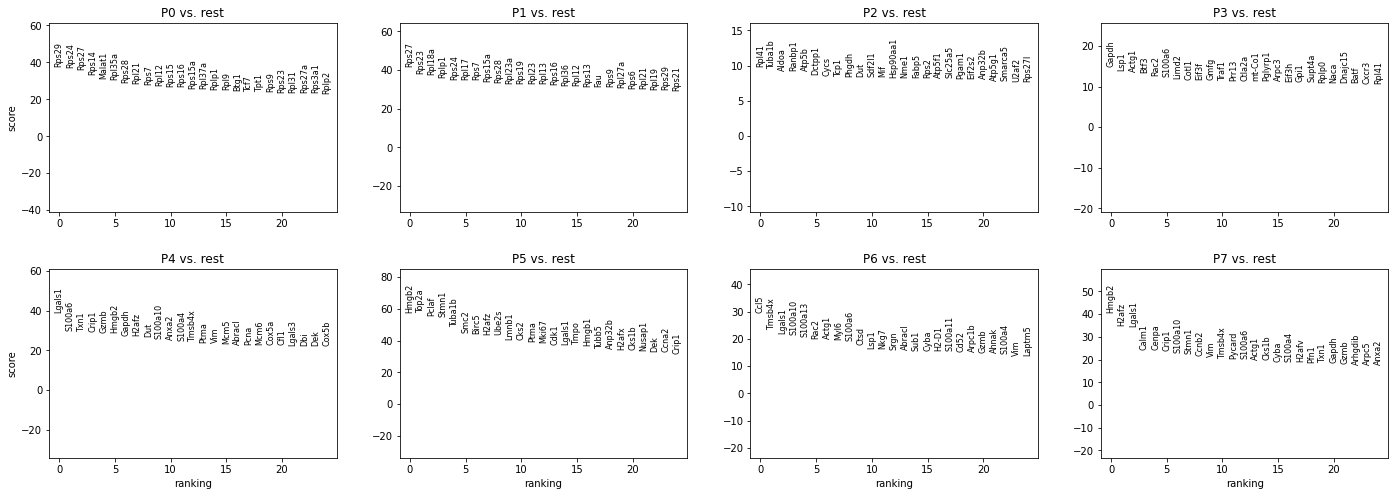

In [14]:
sc.tl.rank_genes_groups(adata, obs_useCol, method='t-test', key_added='t-test',n_genes=gene_n)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key='t-test')

### 1.1.2 T-test overestimated variance

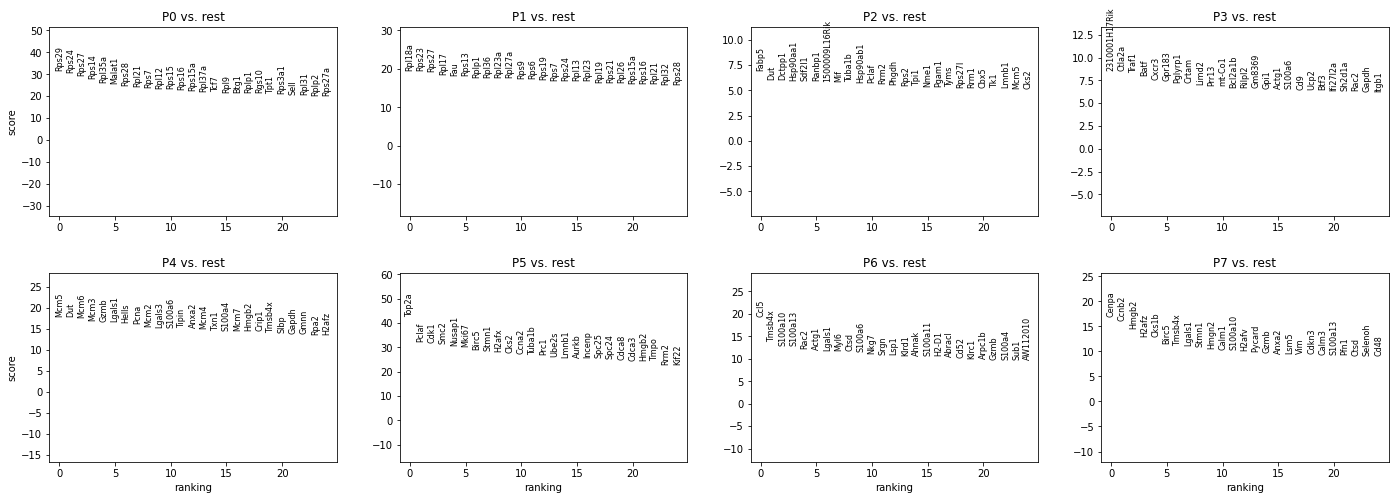

In [15]:
sc.tl.rank_genes_groups(adata, obs_useCol, method='t-test_overestim_var', key_added = "t-test_ov",n_genes=gene_n)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov")

### 1.1.3 Wilconxon rank-sum

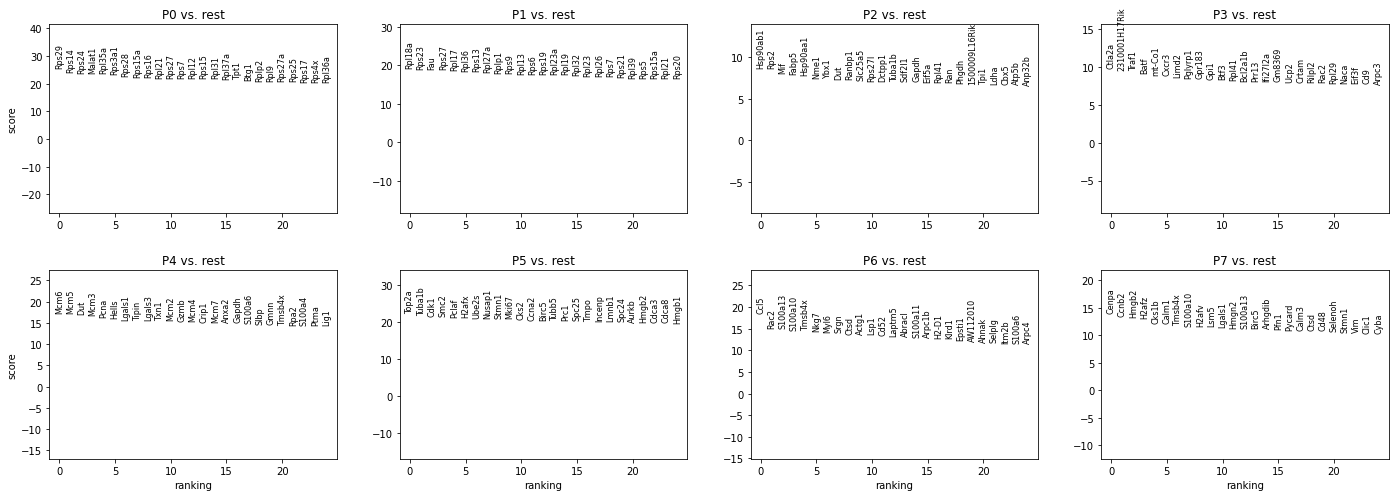

In [16]:
sc.tl.rank_genes_groups(adata, obs_useCol, method='wilcoxon', key_added = "wilcoxon",n_genes=gene_n)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

### 1.1.4 Logistic regression

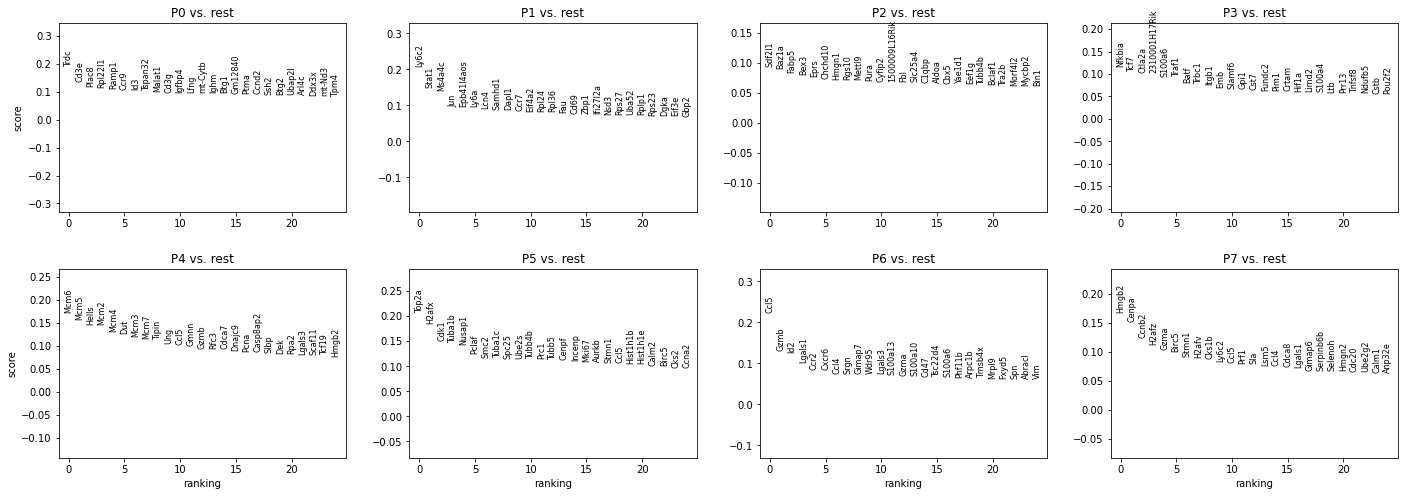

In [17]:
sc.tl.rank_genes_groups(adata, obs_useCol, method='logreg',key_added = "logreg",n_genes=gene_n)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

### 1.1.5 Compare genes

In [18]:
###Redo
os.chdir(cp_dir)

cps = ['wilcoxon', 't-test', 't-test_ov','logreg']


for l_t in labels_uniq:
    genes_df_l_t = pd.DataFrame({"gene_names":all_genes})
    dict_l_t = {}
    for cp in cps:
        if cp != 'logreg':
            cp_names = adata.uns[cp]['names'][l_t]
            cp_fc = adata.uns[cp]['logfoldchanges'][l_t]
            cp_score = adata.uns[cp]['scores'][l_t]
            cp_padj = adata.uns[cp]['pvals_adj'][l_t]
            if (cp == 't-test_ov'):
                cp_name = 't-test_overestim_var'
                cp_df = pd.DataFrame({"gene_names":cp_names, "%s_logfc"%cp_name: cp_fc, "%s_padj"%cp_name:cp_padj, "%s_score"%cp_name:cp_score})
            else:
                cp_df = pd.DataFrame({"gene_names":cp_names, "%s_logfc"%cp: cp_fc, "%s_padj"%cp:cp_padj, "%s_score"%cp:cp_score})

            genes_df_l_t = pd.merge(genes_df_l_t, cp_df, how='outer', on="gene_names")
            cp_df = cp_df[cp_df[cp_df.columns[2]] <= 0.05]
            cp_df = cp_df[cp_df[cp_df.columns[1]] > 0]
            dict_l_t[cp] = cp_df['gene_names']
        else:
            cp_names = adata.uns[cp]['names'][l_t]
            cp_score = adata.uns[cp]['scores'][l_t]
            cp_df = pd.DataFrame({"gene_names":cp_names,  "%s_score"%cp:cp_score})
            genes_df_l_t = pd.merge(genes_df_l_t, cp_df, how='outer', on="gene_names")
    genes_df_l_t.to_csv("%s_differential.csv"%l_t, index=False)
    
    venn3([set(dict_l_t[cps[0]]), set(dict_l_t[cps[1]]), set(dict_l_t[cps[2]])], tuple(cps[:3]))
    
    outname = "%s_venn.png"%l_t
    plt.savefig(outname)
    plt.close()

### 1.1.6 Visualization

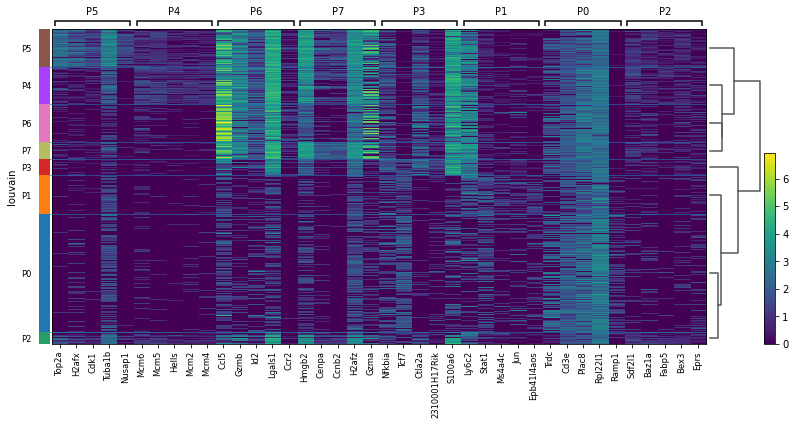

In [19]:
heatmap = sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="logreg", groupby=obs_useCol, 
                                          show_gene_labels=True,save="logreg_heatmap.png")

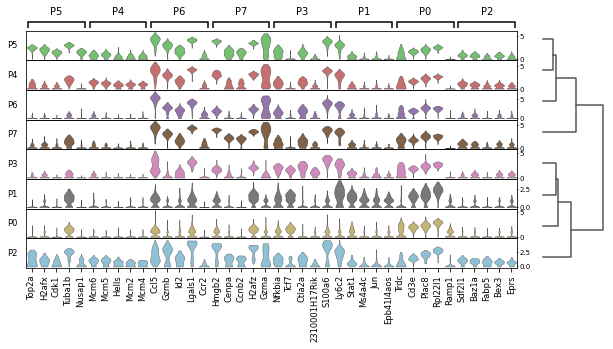

In [20]:
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="logreg", groupby=obs_useCol,
                                      save="logreg_violin.png")

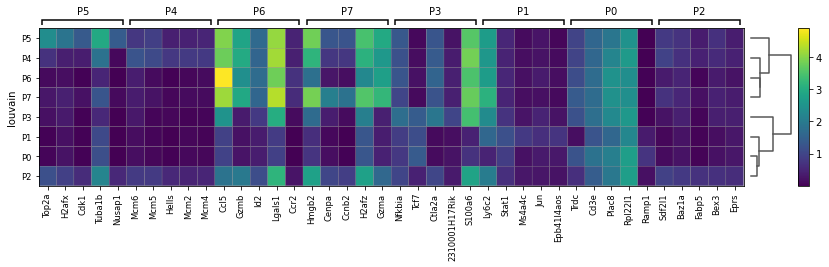

In [21]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="logreg", groupby=obs_useCol,
                                  save="logreg_matrix.png")

-----
# 1.2 Compare specific clusters

In [22]:
# Working directory
cp_dir = de_dir + '/Cluster_vs_Cluster_newNames'
Path(cp_dir).mkdir(parents=True, exist_ok=True)

['P0', 'P1']


Trying to set attribute `.uns` of view, copying.


P0 P1 wilcoxon
P0 P1 t-test
P0 P1 t-test_overestim_var


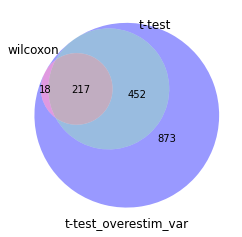

P1 P0 wilcoxon
P1 P0 t-test
P1 P0 t-test_overestim_var


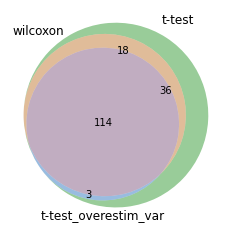

['P0', 'P2']


Trying to set attribute `.uns` of view, copying.


P0 P2 wilcoxon
P0 P2 t-test
P0 P2 t-test_overestim_var


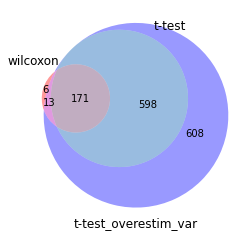

P2 P0 wilcoxon
P2 P0 t-test
P2 P0 t-test_overestim_var


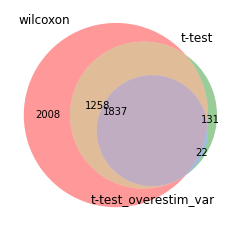

['P0', 'P3']


Trying to set attribute `.uns` of view, copying.


P0 P3 wilcoxon
P0 P3 t-test
P0 P3 t-test_overestim_var


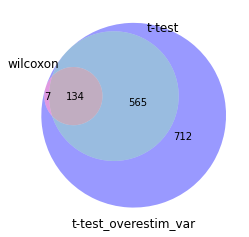

P3 P0 wilcoxon
P3 P0 t-test
P3 P0 t-test_overestim_var


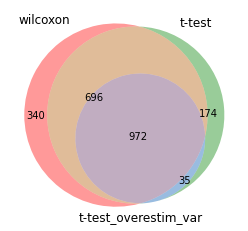

['P0', 'P4']


Trying to set attribute `.uns` of view, copying.


P0 P4 wilcoxon
P0 P4 t-test
P0 P4 t-test_overestim_var


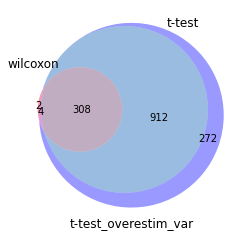

P4 P0 wilcoxon
P4 P0 t-test
P4 P0 t-test_overestim_var


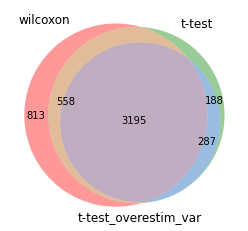

['P0', 'P5']


Trying to set attribute `.uns` of view, copying.


P0 P5 wilcoxon
P0 P5 t-test
P0 P5 t-test_overestim_var


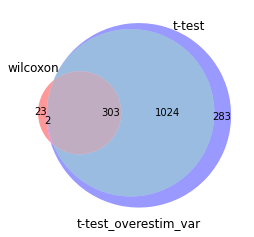

P5 P0 wilcoxon
P5 P0 t-test
P5 P0 t-test_overestim_var


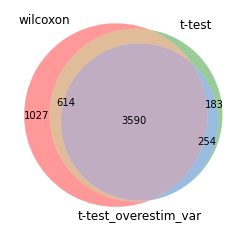

['P0', 'P6']


Trying to set attribute `.uns` of view, copying.


P0 P6 wilcoxon
P0 P6 t-test
P0 P6 t-test_overestim_var


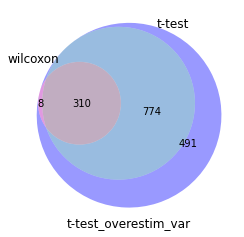

P6 P0 wilcoxon
P6 P0 t-test
P6 P0 t-test_overestim_var


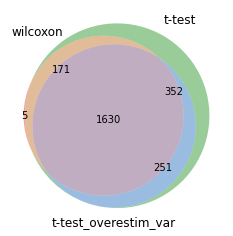

['P0', 'P7']


Trying to set attribute `.uns` of view, copying.


P0 P7 wilcoxon
P0 P7 t-test
P0 P7 t-test_overestim_var


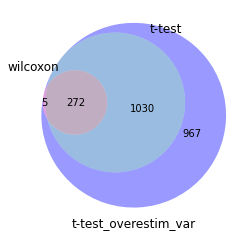

P7 P0 wilcoxon
P7 P0 t-test
P7 P0 t-test_overestim_var


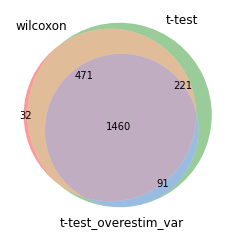

['P0', 'P1']


Trying to set attribute `.uns` of view, copying.


P0 P1 wilcoxon
P0 P1 t-test
P0 P1 t-test_overestim_var


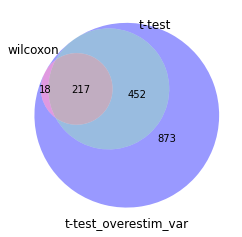

P1 P0 wilcoxon
P1 P0 t-test
P1 P0 t-test_overestim_var


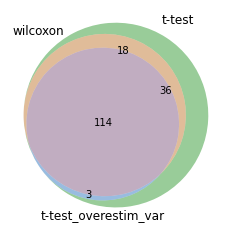

['P1', 'P2']


Trying to set attribute `.uns` of view, copying.


P1 P2 wilcoxon
P1 P2 t-test
P1 P2 t-test_overestim_var


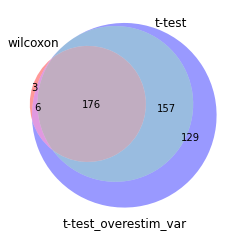

P2 P1 wilcoxon
P2 P1 t-test
P2 P1 t-test_overestim_var


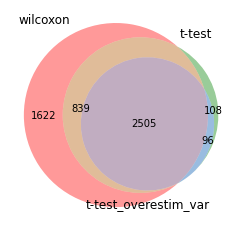

['P1', 'P3']


Trying to set attribute `.uns` of view, copying.


P1 P3 wilcoxon
P1 P3 t-test
P1 P3 t-test_overestim_var


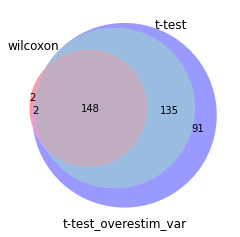

P3 P1 wilcoxon
P3 P1 t-test
P3 P1 t-test_overestim_var


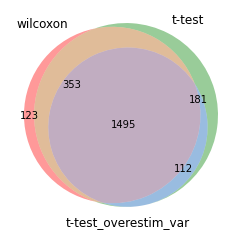

['P1', 'P4']


Trying to set attribute `.uns` of view, copying.


P1 P4 wilcoxon
P1 P4 t-test
P1 P4 t-test_overestim_var


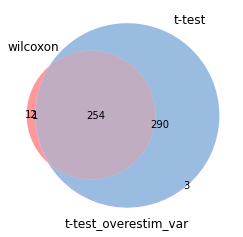

P4 P1 wilcoxon
P4 P1 t-test
P4 P1 t-test_overestim_var


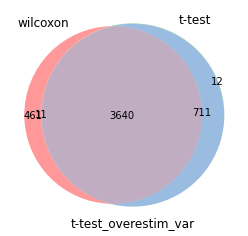

['P1', 'P5']


Trying to set attribute `.uns` of view, copying.


P1 P5 wilcoxon
P1 P5 t-test
P1 P5 t-test_overestim_var


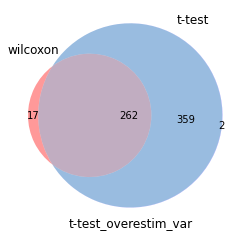

P5 P1 wilcoxon
P5 P1 t-test
P5 P1 t-test_overestim_var


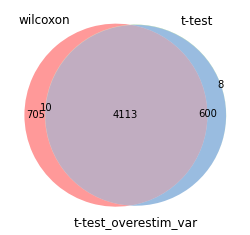

['P1', 'P6']


Trying to set attribute `.uns` of view, copying.


P1 P6 wilcoxon
P1 P6 t-test
P1 P6 t-test_overestim_var


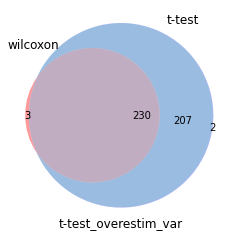

P6 P1 wilcoxon
P6 P1 t-test
P6 P1 t-test_overestim_var


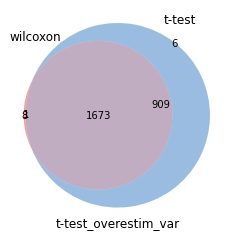

['P1', 'P7']


Trying to set attribute `.uns` of view, copying.


P1 P7 wilcoxon
P1 P7 t-test
P1 P7 t-test_overestim_var


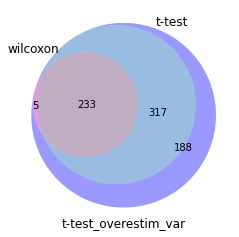

P7 P1 wilcoxon
P7 P1 t-test
P7 P1 t-test_overestim_var


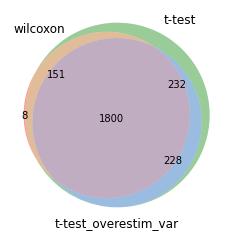

['P0', 'P2']


Trying to set attribute `.uns` of view, copying.


P0 P2 wilcoxon
P0 P2 t-test
P0 P2 t-test_overestim_var


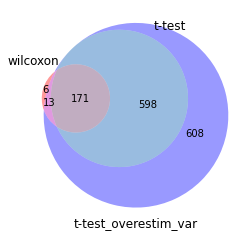

P2 P0 wilcoxon
P2 P0 t-test
P2 P0 t-test_overestim_var


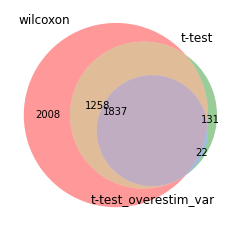

['P1', 'P2']


Trying to set attribute `.uns` of view, copying.


P1 P2 wilcoxon
P1 P2 t-test
P1 P2 t-test_overestim_var


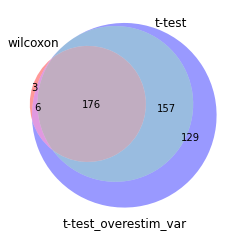

P2 P1 wilcoxon
P2 P1 t-test
P2 P1 t-test_overestim_var


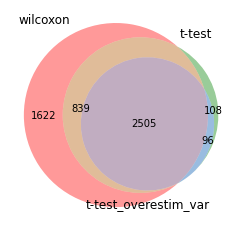

['P2', 'P3']


Trying to set attribute `.uns` of view, copying.


P2 P3 wilcoxon
P2 P3 t-test
P2 P3 t-test_overestim_var


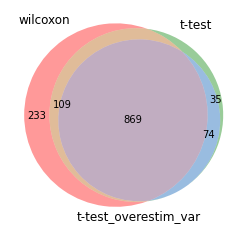

P3 P2 wilcoxon
P3 P2 t-test
P3 P2 t-test_overestim_var


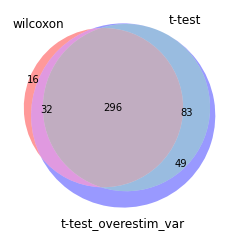

['P2', 'P4']


Trying to set attribute `.uns` of view, copying.


P2 P4 wilcoxon
P2 P4 t-test
P2 P4 t-test_overestim_var


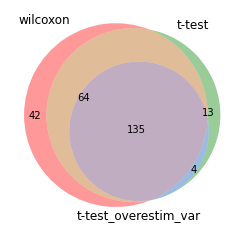

P4 P2 wilcoxon
P4 P2 t-test
P4 P2 t-test_overestim_var


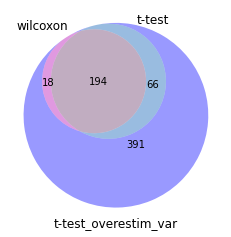

['P2', 'P5']


Trying to set attribute `.uns` of view, copying.


P2 P5 wilcoxon
P2 P5 t-test
P2 P5 t-test_overestim_var


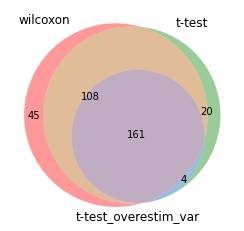

P5 P2 wilcoxon
P5 P2 t-test
P5 P2 t-test_overestim_var


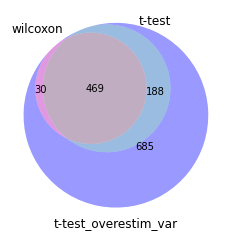

['P2', 'P6']


Trying to set attribute `.uns` of view, copying.


P2 P6 wilcoxon
P2 P6 t-test
P2 P6 t-test_overestim_var


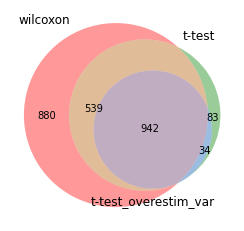

P6 P2 wilcoxon
P6 P2 t-test
P6 P2 t-test_overestim_var


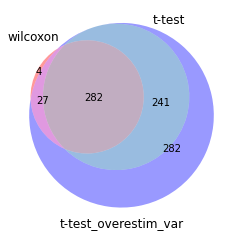

['P2', 'P7']


Trying to set attribute `.uns` of view, copying.


P2 P7 wilcoxon
P2 P7 t-test
P2 P7 t-test_overestim_var


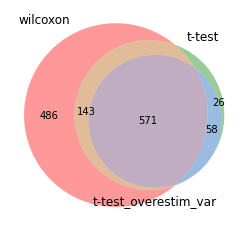

P7 P2 wilcoxon
P7 P2 t-test
P7 P2 t-test_overestim_var


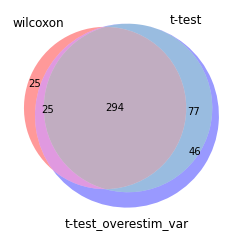

['P0', 'P3']


Trying to set attribute `.uns` of view, copying.


P0 P3 wilcoxon
P0 P3 t-test
P0 P3 t-test_overestim_var


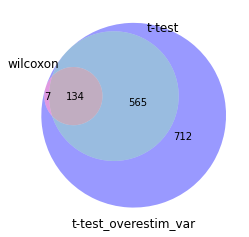

P3 P0 wilcoxon
P3 P0 t-test
P3 P0 t-test_overestim_var


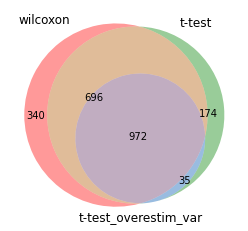

['P1', 'P3']


Trying to set attribute `.uns` of view, copying.


P1 P3 wilcoxon
P1 P3 t-test
P1 P3 t-test_overestim_var


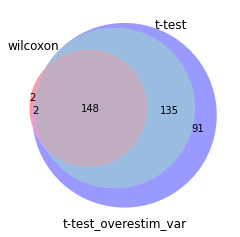

P3 P1 wilcoxon
P3 P1 t-test
P3 P1 t-test_overestim_var


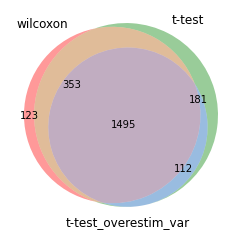

['P2', 'P3']


Trying to set attribute `.uns` of view, copying.


P2 P3 wilcoxon
P2 P3 t-test
P2 P3 t-test_overestim_var


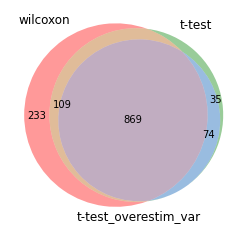

P3 P2 wilcoxon
P3 P2 t-test
P3 P2 t-test_overestim_var


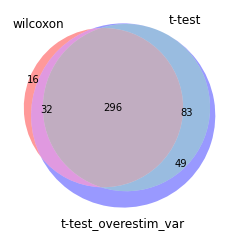

['P3', 'P4']


Trying to set attribute `.uns` of view, copying.


P3 P4 wilcoxon
P3 P4 t-test
P3 P4 t-test_overestim_var


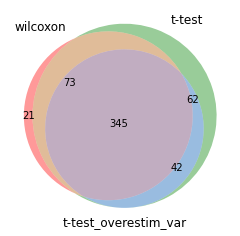

P4 P3 wilcoxon
P4 P3 t-test
P4 P3 t-test_overestim_var


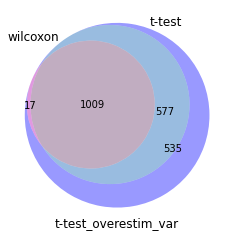

['P3', 'P5']


Trying to set attribute `.uns` of view, copying.


P3 P5 wilcoxon
P3 P5 t-test
P3 P5 t-test_overestim_var


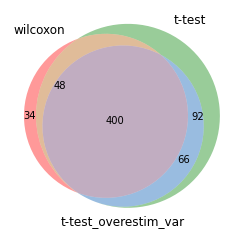

P5 P3 wilcoxon
P5 P3 t-test
P5 P3 t-test_overestim_var


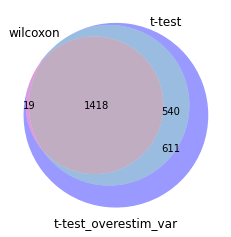

['P3', 'P6']


Trying to set attribute `.uns` of view, copying.


P3 P6 wilcoxon
P3 P6 t-test
P3 P6 t-test_overestim_var


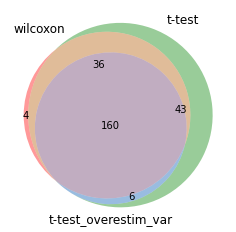

P6 P3 wilcoxon
P6 P3 t-test
P6 P3 t-test_overestim_var


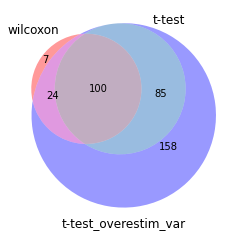

['P3', 'P7']


Trying to set attribute `.uns` of view, copying.


P3 P7 wilcoxon
P3 P7 t-test
P3 P7 t-test_overestim_var


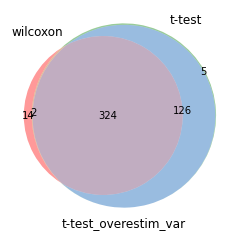

P7 P3 wilcoxon
P7 P3 t-test
P7 P3 t-test_overestim_var


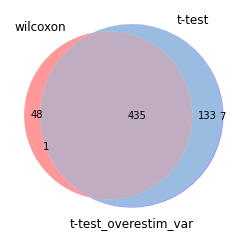

['P0', 'P4']


Trying to set attribute `.uns` of view, copying.


P0 P4 wilcoxon
P0 P4 t-test
P0 P4 t-test_overestim_var


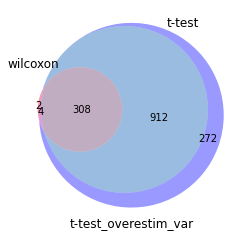

P4 P0 wilcoxon
P4 P0 t-test
P4 P0 t-test_overestim_var


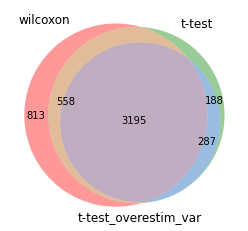

['P1', 'P4']


Trying to set attribute `.uns` of view, copying.


P1 P4 wilcoxon
P1 P4 t-test
P1 P4 t-test_overestim_var


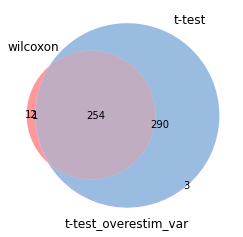

P4 P1 wilcoxon
P4 P1 t-test
P4 P1 t-test_overestim_var


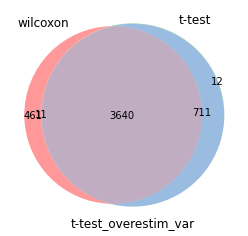

['P2', 'P4']


Trying to set attribute `.uns` of view, copying.


P2 P4 wilcoxon
P2 P4 t-test
P2 P4 t-test_overestim_var


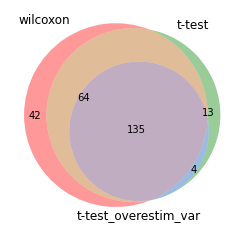

P4 P2 wilcoxon
P4 P2 t-test
P4 P2 t-test_overestim_var


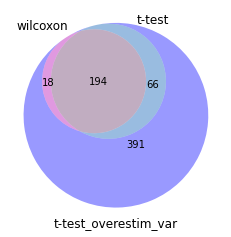

['P3', 'P4']


Trying to set attribute `.uns` of view, copying.


P3 P4 wilcoxon
P3 P4 t-test
P3 P4 t-test_overestim_var


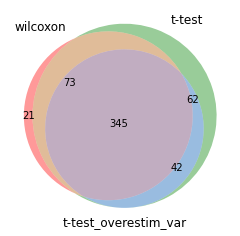

P4 P3 wilcoxon
P4 P3 t-test
P4 P3 t-test_overestim_var


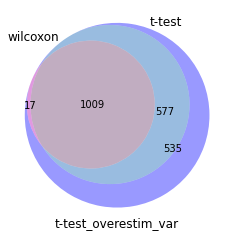

['P4', 'P5']


Trying to set attribute `.uns` of view, copying.


P4 P5 wilcoxon
P4 P5 t-test
P4 P5 t-test_overestim_var


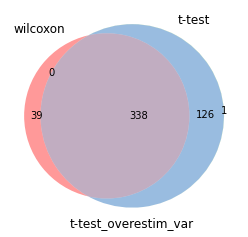

P5 P4 wilcoxon
P5 P4 t-test
P5 P4 t-test_overestim_var


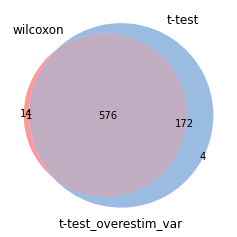

['P4', 'P6']


Trying to set attribute `.uns` of view, copying.


P4 P6 wilcoxon
P4 P6 t-test
P4 P6 t-test_overestim_var


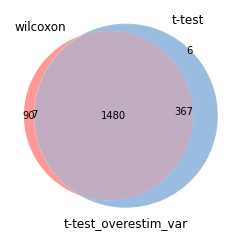

P6 P4 wilcoxon
P6 P4 t-test
P6 P4 t-test_overestim_var


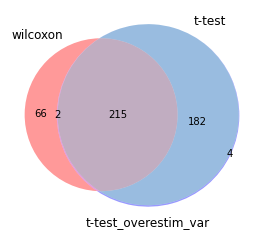

['P4', 'P7']


Trying to set attribute `.uns` of view, copying.


P4 P7 wilcoxon
P4 P7 t-test
P4 P7 t-test_overestim_var


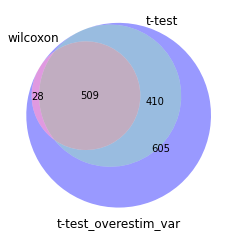

P7 P4 wilcoxon
P7 P4 t-test
P7 P4 t-test_overestim_var


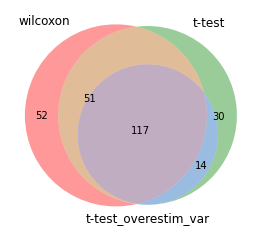

['P0', 'P5']


Trying to set attribute `.uns` of view, copying.


P0 P5 wilcoxon
P0 P5 t-test
P0 P5 t-test_overestim_var


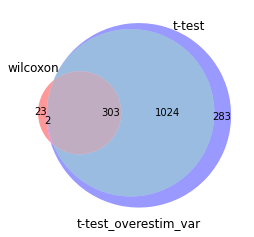

P5 P0 wilcoxon
P5 P0 t-test
P5 P0 t-test_overestim_var


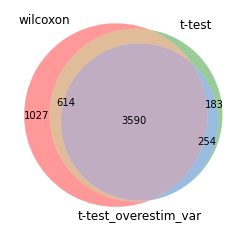

['P1', 'P5']


Trying to set attribute `.uns` of view, copying.


P1 P5 wilcoxon
P1 P5 t-test
P1 P5 t-test_overestim_var


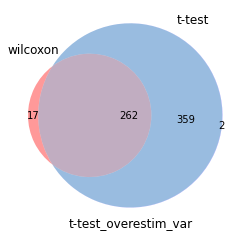

P5 P1 wilcoxon
P5 P1 t-test
P5 P1 t-test_overestim_var


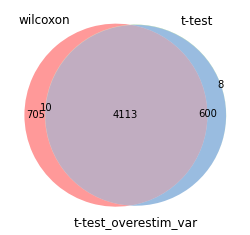

['P2', 'P5']


Trying to set attribute `.uns` of view, copying.


P2 P5 wilcoxon
P2 P5 t-test
P2 P5 t-test_overestim_var


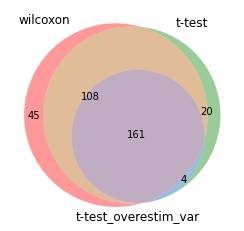

P5 P2 wilcoxon
P5 P2 t-test
P5 P2 t-test_overestim_var


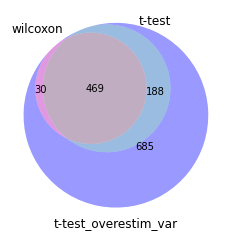

['P3', 'P5']


Trying to set attribute `.uns` of view, copying.


P3 P5 wilcoxon
P3 P5 t-test
P3 P5 t-test_overestim_var


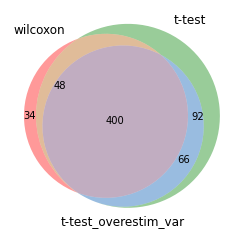

P5 P3 wilcoxon
P5 P3 t-test
P5 P3 t-test_overestim_var


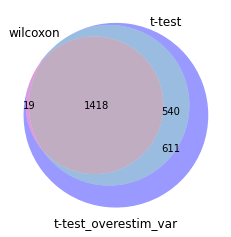

['P4', 'P5']


Trying to set attribute `.uns` of view, copying.


P4 P5 wilcoxon
P4 P5 t-test
P4 P5 t-test_overestim_var


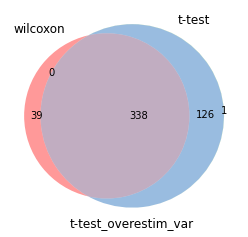

P5 P4 wilcoxon
P5 P4 t-test
P5 P4 t-test_overestim_var


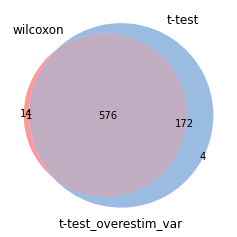

['P5', 'P6']


Trying to set attribute `.uns` of view, copying.


P5 P6 wilcoxon
P5 P6 t-test
P5 P6 t-test_overestim_var


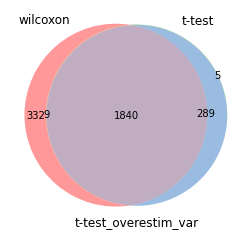

P6 P5 wilcoxon
P6 P5 t-test
P6 P5 t-test_overestim_var


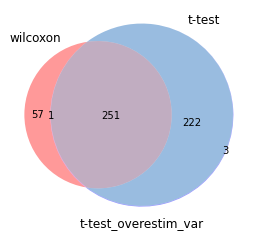

['P5', 'P7']


Trying to set attribute `.uns` of view, copying.


P5 P7 wilcoxon
P5 P7 t-test
P5 P7 t-test_overestim_var


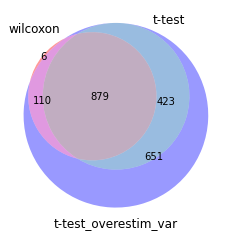

P7 P5 wilcoxon
P7 P5 t-test
P7 P5 t-test_overestim_var


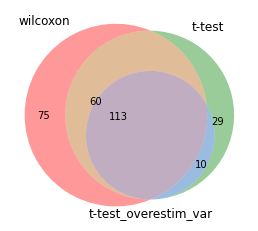

['P0', 'P6']


Trying to set attribute `.uns` of view, copying.


P0 P6 wilcoxon
P0 P6 t-test
P0 P6 t-test_overestim_var


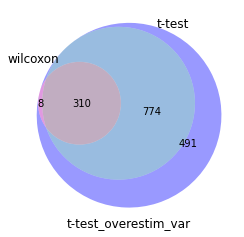

P6 P0 wilcoxon
P6 P0 t-test
P6 P0 t-test_overestim_var


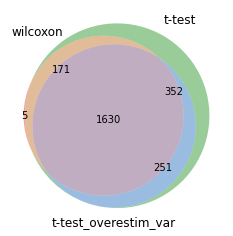

['P1', 'P6']


Trying to set attribute `.uns` of view, copying.


P1 P6 wilcoxon
P1 P6 t-test
P1 P6 t-test_overestim_var


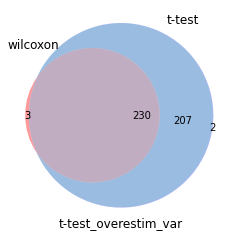

P6 P1 wilcoxon
P6 P1 t-test
P6 P1 t-test_overestim_var


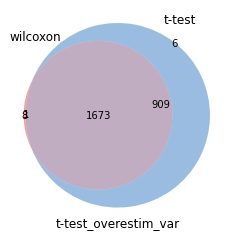

['P2', 'P6']


Trying to set attribute `.uns` of view, copying.


P2 P6 wilcoxon
P2 P6 t-test
P2 P6 t-test_overestim_var


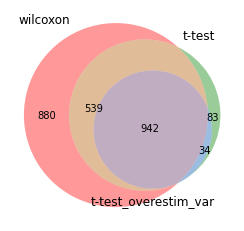

P6 P2 wilcoxon
P6 P2 t-test
P6 P2 t-test_overestim_var


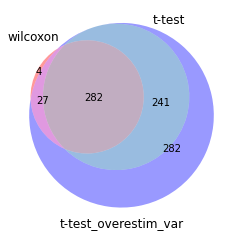

['P3', 'P6']


Trying to set attribute `.uns` of view, copying.


P3 P6 wilcoxon
P3 P6 t-test
P3 P6 t-test_overestim_var


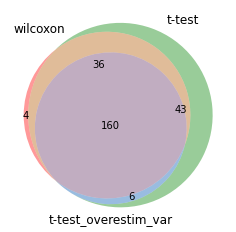

P6 P3 wilcoxon
P6 P3 t-test
P6 P3 t-test_overestim_var


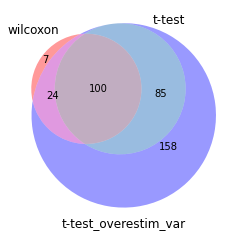

['P4', 'P6']


Trying to set attribute `.uns` of view, copying.


P4 P6 wilcoxon
P4 P6 t-test
P4 P6 t-test_overestim_var


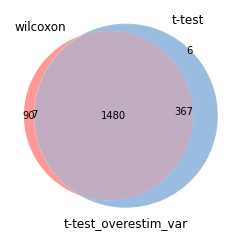

P6 P4 wilcoxon
P6 P4 t-test
P6 P4 t-test_overestim_var


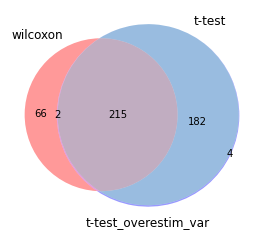

['P5', 'P6']


Trying to set attribute `.uns` of view, copying.


P5 P6 wilcoxon
P5 P6 t-test
P5 P6 t-test_overestim_var


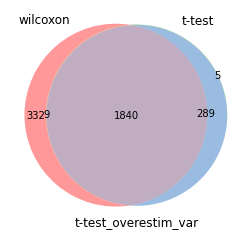

P6 P5 wilcoxon
P6 P5 t-test
P6 P5 t-test_overestim_var


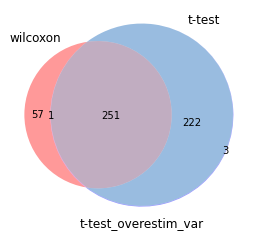

['P6', 'P7']


Trying to set attribute `.uns` of view, copying.


P6 P7 wilcoxon
P6 P7 t-test
P6 P7 t-test_overestim_var


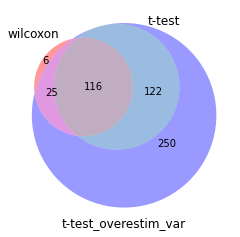

P7 P6 wilcoxon
P7 P6 t-test
P7 P6 t-test_overestim_var


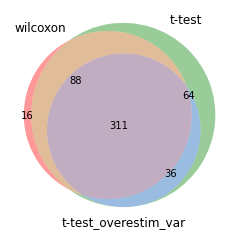

['P0', 'P7']


Trying to set attribute `.uns` of view, copying.


P0 P7 wilcoxon
P0 P7 t-test
P0 P7 t-test_overestim_var


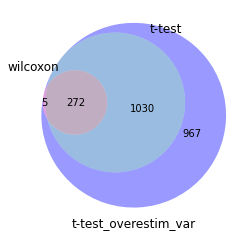

P7 P0 wilcoxon
P7 P0 t-test
P7 P0 t-test_overestim_var


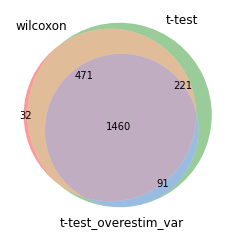

['P1', 'P7']


Trying to set attribute `.uns` of view, copying.


P1 P7 wilcoxon
P1 P7 t-test
P1 P7 t-test_overestim_var


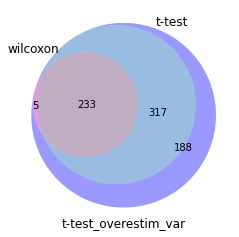

P7 P1 wilcoxon
P7 P1 t-test
P7 P1 t-test_overestim_var


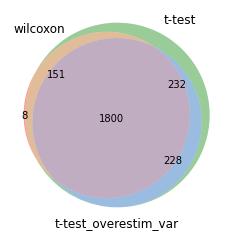

['P2', 'P7']


Trying to set attribute `.uns` of view, copying.


P2 P7 wilcoxon
P2 P7 t-test
P2 P7 t-test_overestim_var


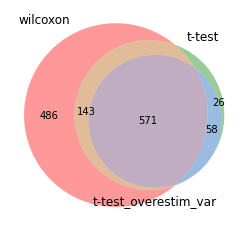

P7 P2 wilcoxon
P7 P2 t-test
P7 P2 t-test_overestim_var


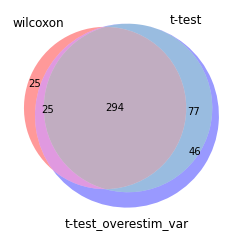

['P3', 'P7']


Trying to set attribute `.uns` of view, copying.


P3 P7 wilcoxon
P3 P7 t-test
P3 P7 t-test_overestim_var


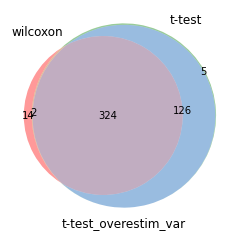

P7 P3 wilcoxon
P7 P3 t-test
P7 P3 t-test_overestim_var


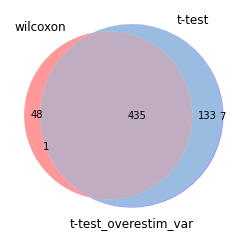

['P4', 'P7']


Trying to set attribute `.uns` of view, copying.


P4 P7 wilcoxon
P4 P7 t-test
P4 P7 t-test_overestim_var


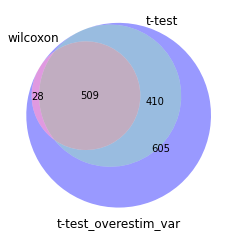

P7 P4 wilcoxon
P7 P4 t-test
P7 P4 t-test_overestim_var


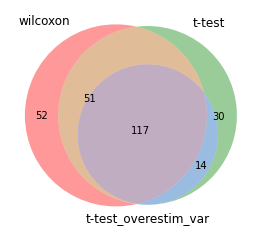

['P5', 'P7']


Trying to set attribute `.uns` of view, copying.


P5 P7 wilcoxon
P5 P7 t-test
P5 P7 t-test_overestim_var


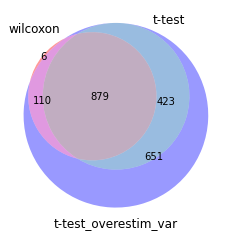

P7 P5 wilcoxon
P7 P5 t-test
P7 P5 t-test_overestim_var


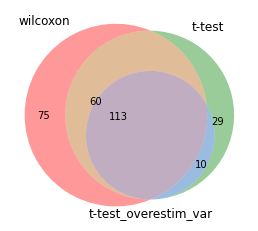

['P6', 'P7']


Trying to set attribute `.uns` of view, copying.


P6 P7 wilcoxon
P6 P7 t-test
P6 P7 t-test_overestim_var


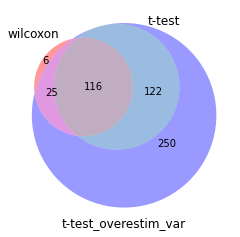

P7 P6 wilcoxon
P7 P6 t-test
P7 P6 t-test_overestim_var


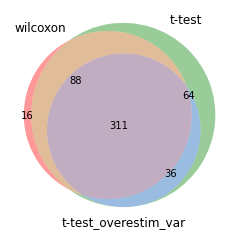

In [24]:
### Config
obs_useCol = 'louvain'
cps = ['wilcoxon', 't-test', 't-test_overestim_var']

louvain_unique =  list(set(adata.obs['louvain']))
louvain_unique.sort()
louvain_unique = [str(x) for x in louvain_unique]

### Compare
for i in louvain_unique:
    for j in louvain_unique:
        if i != j:
            adata_ij = adata.copy()
            adata_ij = adata_ij[[True if x in [i,j] else False for x in adata_ij.obs['louvain'].values],:]
            sc_addons.multitest_venn(adata_ij, cps, obs_useCol, cp_dir)